# EE461P Term Project: Predicting Hotel Bookings on Expedia

### Group Members
1. Zander Tedjo (zbt86)
2. Alex Li
3. Shiv Lalapet
4. James Lu

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

#https://www.kaggle.com/c/expedia-hotel-recommendations


## Data preparation

In [2]:
# Import original raw data
df_raw = pd.read_csv('expedia.csv')
print(df_raw.shape)
#print(df_raw.head())


             date_time  site_name  posa_continent  user_location_country  \
0  2014-08-11 07:46:59          2               3                     66   
1  2014-08-11 08:22:12          2               3                     66   
2  2014-08-11 08:24:33          2               3                     66   
3  2014-08-09 18:05:16          2               3                     66   
4  2014-08-09 18:08:18          2               3                     66   

   user_location_region  user_location_city  orig_destination_distance  \
0                   348               48862                  2234.2641   
1                   348               48862                  2234.2641   
2                   348               48862                  2234.2641   
3                   442               35390                   913.1932   
4                   442               35390                   913.6259   

   user_id  is_mobile  is_package  ...  srch_children_cnt srch_rm_cnt  \
0       12          0    

In [14]:
# Remove rows with missing values
df_clean = df_raw.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
print(df_clean.shape)

(24117894, 24)


In [15]:
#df_clean.to_csv('expedia_clean.csv', index=False)

In [53]:
# Resample randomly
from sklearn.utils import resample

size = 100000
df_resampled_random = resample(df_clean, replace=False, n_samples=size, random_state=42)    

print(df_resampled_random.shape)


(100000, 24)


In [54]:
df_resampled_random.to_csv('expedia_resampled_random.csv', index=False)

In [56]:
# Resample for equal class distributions
from sklearn.utils import resample

df_resampled_equal = pd.DataFrame()
class_size = 1000
classes = data_clean['hotel_cluster'].unique()

for c in classes:
    class_data = df_clean[df_clean.hotel_cluster == c]
    class_data_resampled = resample(class_data, replace=False, n_samples=class_size, random_state=42)    
    df_resampled_equal = pd.concat([df_resampled_equal, class_data_resampled])

print(df_resampled_equal.shape)

(100000, 24)


In [57]:
df_resampled_equal.to_csv('expedia_resampled_equal.csv', index=False)

## Data exploration

In [2]:
# Load resampled data
df_resampled_random = pd.read_csv('expedia_resampled_random.csv')
df_resampled_equal = pd.read_csv('expedia_resampled_equal.csv')


Text(0.5, 0, 'Hotel cluster')

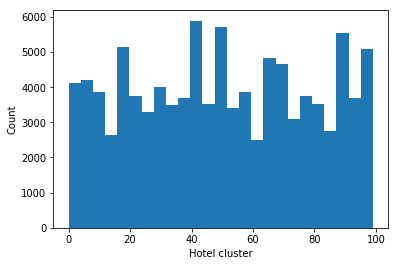

In [3]:
# Plot target label distribution of random resampling
plt.hist(df_resampled_random['hotel_cluster'], bins=25)
plt.ylabel('Count')
plt.xlabel('Hotel cluster')

Text(0.5, 0, 'Hotel cluster')

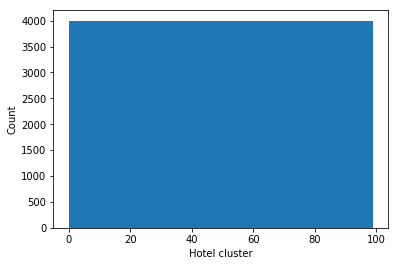

In [4]:
# Plot target label distribution of equal resampling
plt.hist(df_resampled_equal['hotel_cluster'], bins=25)
plt.ylabel('Count')
plt.xlabel('Hotel cluster')

In [5]:
# Drop unnecessary features

#df_dropped = df_resampled_random.copy()
df_dropped = df_resampled_equal.copy()

df_dropped = df_dropped.drop(['date_time'], axis=1)
df_dropped = df_dropped.drop(['user_id'], axis=1)
df_dropped = df_dropped.drop(['srch_ci'], axis=1)
df_dropped = df_dropped.drop(['srch_co'], axis=1)
df_dropped = df_dropped.drop(['site_name'], axis=1)

print(df_dropped.shape)
print(df_dropped.columns)
print(df_dropped.head())

(100000, 19)
Index(['posa_continent', 'user_location_country', 'user_location_region',
       'user_location_city', 'orig_destination_distance', 'is_mobile',
       'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')
   posa_continent  user_location_country  user_location_region  \
0               3                     66                   337   
1               3                     66                   174   
2               3                    205                   343   
3               1                     46                   242   
4               3                     66                   363   

   user_location_city  orig_destination_distance  is_mobile  is_package  \
0               11682                  2214.1679          1           1   
1                6735  

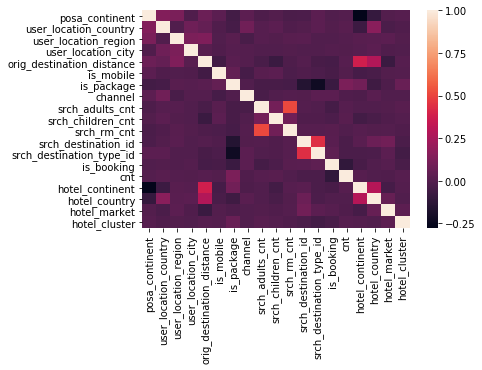

In [6]:
# Correlation heatmap
import seaborn as sns

corr = df_dropped.corr()
ax = sns.heatmap(corr)

Text(0.5, 0, 'user_location_country')

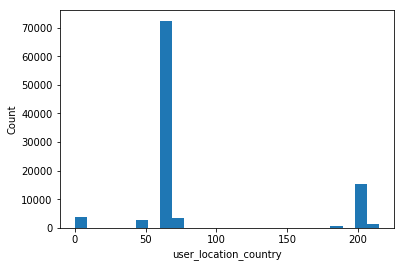

In [7]:
# Plot distribution of a feature
feature = 'srch_rm_cnt'
feature = 'posa_continent'
feature = 'user_location_country'


plt.hist(df_dropped[feature], bins=25)
plt.ylabel('Count')
plt.xlabel(feature)

## Preprocessing

In [8]:
# Get dummies for categorical features
data = pd.get_dummies(df_dropped)
print(data.shape)

(100000, 19)


In [9]:
X = data.drop(['hotel_cluster'], axis=1)
Y = data['hotel_cluster']

In [10]:
# Select top K features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

n = 8
selector = SelectKBest(chi2, k=n)
X_new = selector.fit_transform(X, Y)

print(X_new.shape)
#print(X_new.columns)

mask = selector.get_support()
new_features = X.columns[mask]
print(new_features)

(100000, 8)
Index(['user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'srch_destination_id', 'hotel_continent',
       'hotel_country', 'hotel_market'],
      dtype='object')


In [11]:
from sklearn.model_selection import train_test_split

# Normal data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Feature selection data
#X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.25, random_state=42)

print(X_train.shape)

(75000, 18)


## K-Means Clustering

In [13]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, log_loss, average_precision_score

def multiclass_roc_auc_score(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred)

def evaluate(y_test, y_test_pred, y_test_pred_proba):
    accuracy = accuracy_score(y_test, y_test_pred)
    print('Accuracy', accuracy)

    #auc = roc_auc_score(y_test, y_test_pred, multi_class='ovr')
    auc = multiclass_roc_auc_score(y_test, y_test_pred)
    
    #binary auc
    #auc = roc_auc_score(y_test, y_test_pred_proba[:,1])

    print('AUC', auc)

    cross_entropy = log_loss(y_test, y_test_pred_proba)
    print('Cross entropy', cross_entropy)

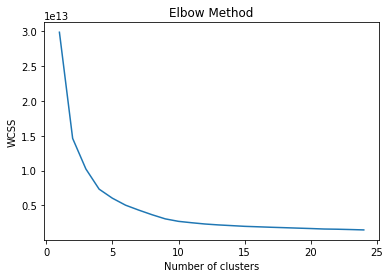

In [32]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

#Use Elbow method to determine number of clusters
wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [20]:
from sklearn.cluster import KMeans

# Number of clusters
kmeans = KMeans(n_clusters=10, max_iter = 1000).fit(X_train)

y_test_pred = kmeans.predict(X_test)

# Centroid values
centroids = kmeans.cluster_centers_

accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy', accuracy)

auc = multiclass_roc_auc_score(y_test, y_test_pred)
print('AUC', auc)

#print(centroids)

Accuracy 0.0104
AUC 0.5002837876831098


C:\Users\Alex Li\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\Alex Li\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:735: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


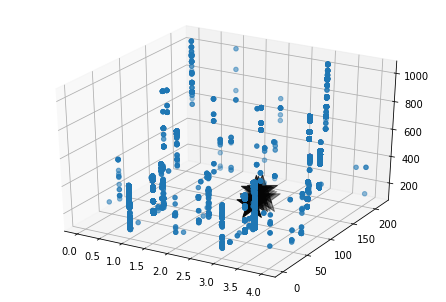

In [34]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_train.values[:, 0], X_train.values[:, 1], X_train.values[:, 2], X_train.values[:,3])
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], centroids[:, 3], marker='*', c='#050505', s=1000)

## PCA

In [12]:
#PCA breakdown into 100, 30, and 10 components
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

pca18 = PCA(n_components = 18)
pca10 = PCA(n_components = 10)
pca5 = PCA(n_components = 5)

X_18pca = pca18.fit_transform(X)
X_10pca = pca10.fit_transform(X)
X_5pca = pca5.fit_transform(X)

In [14]:
#Running for 18 PCA
x_train_18 = pca18.fit_transform(X_train)
x_test_18 = pca18.fit_transform(X_test)

rand_forest18pca = RandomForestClassifier(n_estimators = 5, random_state = 42)
rand_forest18pca.fit(x_train_18,y_train)

y_pred_18 = rand_forest18pca.predict(x_test_18)
print("Classification report for 18 PCA")
report = classification_report(y_test, y_pred_18)
print(report)

Classification report for 18 PCA
              precision    recall  f1-score   support

           0       0.05      0.18      0.08       243
           1       0.13      0.32      0.19       248
           2       0.03      0.13      0.05       235
           3       0.02      0.06      0.03       263
           4       0.03      0.11      0.05       241
           5       0.01      0.03      0.02       252
           6       0.03      0.10      0.04       251
           7       0.04      0.12      0.06       255
           8       0.09      0.21      0.13       257
           9       0.02      0.04      0.02       244
          10       0.01      0.02      0.01       265
          11       0.03      0.06      0.04       262
          12       0.05      0.11      0.07       263
          13       0.02      0.05      0.03       258
          14       0.01      0.02      0.02       267
          15       0.02      0.04      0.03       240
          16       0.02      0.03      0.02     

In [15]:
#Running for 10 PCA
x_train_10 = pca10.fit_transform(X_train)
x_test_10 = pca10.fit_transform(X_test)

rand_forest10pca = RandomForestClassifier(n_estimators = 5, random_state = 42)
rand_forest10pca.fit(x_train_10,y_train)

y_pred_10 = rand_forest10pca.predict(x_test_10)
print("Classification report for 10 PCA")
report = classification_report(y_test, y_pred_10)
print(report)


Classification report for 10 PCA
              precision    recall  f1-score   support

           0       0.05      0.16      0.08       243
           1       0.13      0.29      0.18       248
           2       0.03      0.13      0.05       235
           3       0.03      0.08      0.04       263
           4       0.03      0.09      0.05       241
           5       0.03      0.08      0.04       252
           6       0.03      0.08      0.04       251
           7       0.03      0.09      0.05       255
           8       0.09      0.18      0.12       257
           9       0.02      0.05      0.03       244
          10       0.02      0.04      0.03       265
          11       0.05      0.10      0.07       262
          12       0.04      0.08      0.06       263
          13       0.04      0.09      0.05       258
          14       0.02      0.04      0.03       267
          15       0.02      0.05      0.03       240
          16       0.02      0.04      0.03     

In [16]:
#Running for 5 PCA
x_train_5 = pca5.fit_transform(X_train)
x_test_5 = pca5.fit_transform(X_test)

rand_forest5pca = RandomForestClassifier(n_estimators = 5, random_state = 42)
rand_forest5pca.fit(x_train_5,y_train)

y_pred_5 = rand_forest5pca.predict(x_test_5)
print("Classification report for 5 PCA")
report = classification_report(y_test, y_pred_5)
print(report)


Classification report for 5 PCA
              precision    recall  f1-score   support

           0       0.05      0.17      0.08       243
           1       0.13      0.29      0.18       248
           2       0.03      0.12      0.05       235
           3       0.02      0.07      0.03       263
           4       0.04      0.11      0.05       241
           5       0.01      0.04      0.02       252
           6       0.03      0.08      0.04       251
           7       0.04      0.12      0.06       255
           8       0.07      0.16      0.10       257
           9       0.04      0.11      0.06       244
          10       0.02      0.04      0.02       265
          11       0.03      0.06      0.04       262
          12       0.05      0.09      0.06       263
          13       0.03      0.07      0.04       258
          14       0.03      0.04      0.03       267
          15       0.02      0.03      0.02       240
          16       0.04      0.06      0.05      